# <font color="#000099">llm-d-benchmarking Inference Scheduler Analysis</font>

This notebook imports benchmark report data from configuration sweeps from [llm-d-benchmark](https://github.com/llm-d/llm-d-benchmark), and investigates inference scheduler performance for a single scheduling profile.

The first cell contains function and class definitions to support basic functionality, while the second cell imports data from user-provided directories into [Pandas](https://pandas.pydata.org/) [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). The cells following plot results from the imported data, grouping them into "scenarios" with certain common features.

While the basic functionality here may be sufficient for many purposes, this notebook should be considered a starting point for more detailed analysis and customization by the user.

## Package imports and definitions (run once)

In [11]:
################################################################################
# Package imports
################################################################################

import os
import sys
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas

#sys.path.insert(0, '../workload/report/')
import convert
import schema


class Text:
    """ANSI SGR control codes for text formatting"""
    DEFAULT = "\x1b[0m"
    BOLD = "\x1b[1m"
    BOLD_OFF = "\x1b[22m"
    UNDERLINE = "\x1b[4m"
    UNDERLINE_OFF = "\x1b[24m"
    DEFAULT_COLOR = "\x1b[39m"
    DEFAULT_BG_COLOR = "\x1b[49m"
    RED = "\x1b[31m"
    YELLOW = "\x1b[33m"
    GREEN = "\x1b[32m"
    CYAN = "\x1b[36m"
    BLUE = "\x1b[34m"
    MAGENTA = "\x1b[35m"
    BLACK = "\x1b[30m"
    WHITE = "\x1b[37m"
    BG_RED = "\x1b[41m"
    BG_YELLOW = "\x1b[43m"
    BG_GREEN = "\x1b[42m"
    BG_CYAN = "\x1b[46m"
    BG_BLUE = "\x1b[44m"
    BG_MAGENTA = "\x1b[45m"
    BG_BLACK = "\x1b[40m"
    BG_WHITE = "\x1b[47m"


def info(mesg: str) -> None:
    """Print information message.

    Args:
        mesg (str): Information message.
    """
    sys.stderr.write(f'{Text.GREEN}{mesg}\n{Text.DEFAULT}')


def warn(mesg: str) -> None:
    """Print a warning message.

    Args:
        mesg (str): Warming message.
    """
    sys.stderr.write(f'{Text.YELLOW}{mesg}\n{Text.DEFAULT}')


def error(mesg: str, err_code: int = 1) -> None:
    """Print an error message and exit with an error code.

    Args:
        mesg (str): Error message.
        err_code (int): Error code.
    """
    sys.stderr.write(f'{Text.RED}{mesg}\n{Text.DEFAULT}')
    sys.exit(err_code)


def check_dir(dir: str) -> None:
    """Print an error if directory does not exist.

    Args:
        dir (str): Directory to check existence of.
    """
    if not os.path.isdir(dir):
        error(f'Invalid path: {dir}')


def check_file(file: str) -> None:
    """Print an error if file does not exist.

    Args:
        file (str): File to check existence of.
    """
    if not os.path.isfile(file):
        error(f'Invalid file: {file}')


def get_benchmark_report_files(source_dir: str) -> list[str]:
    """Get a list of benchmark report files within provided path (recursive).

    Args:
        source_dir (str): Directory to recursively search for results files.
    
    Returns:
        list: List of paths to benchmark report files.
    """
    rb_files = []
    check_dir(source_dir)
    path = Path(source_dir)
    for file in path.rglob("benchmark_report,_*.yaml"):
        rb_files.append(str(file))
    return rb_files


def make_benchmark_runs_df() -> pandas.core.frame.DataFrame:
    """Create DataFrame for benchmark run results.

    Returns:
        DataFrame: Empty DataFrame for benchmark runs.
    """
    return pandas.DataFrame(columns=[
        'Name',
        'Directory',
        'Model',
        'GPU',
        'ISL',
        'OSL',
        'Duration',
        'Total_Requests',
        'Failures',
        'Request_Throughput',
        'Output_Token_Throughput',
        'Total_Token_Throughput',
        'Mean_TTFT_ms',
        'Mean_TPOT_ms',
        'Mean_ITL_ms',
        'Mean_E2EL_ms',
        'KV_Cache_Scorer_Weight',
        'Queue_Scorer_Weight',
        'Prefix_Cache_Scorer_Weight',
        'Prefix_Cache_Scorer_Block_Size',
        'Prefix_Cache_Scorer_LRU_Capacity_Per_Server',
        'Prefix_Cache_Scorer_Max_Blocks_To_Match',
        'Prefix_Cache_Scorer_Tracking',
        'System_Prompt_Length',
        'Question_Length',
        'Approx_OSL',
        'Groups',
        'Prompts_Per_Group',
        'QPS',
    ])


def _make_name(report: schema.BenchmarkReport) -> str:
    """Create a name based on the benchmark run's configuration.

    Args:
        report (BenchmarkReport): Benchmark report to create a name for.

    Returns:
        str: Name of benchmark run.
    """
    return 'name'


def add_benchmark_report_to_df(
    runs_df: pandas.core.frame.DataFrame,
    br_file: str) -> None:
    """Load a results file and add it to the DataFrame of benchmark runs.

    Args:
        runs_df (DataFrame): DataFrame to add a row to for the provided run.
        br_file (str): Benchmark report file to import.
    """
    report = convert.import_benchmark_report(br_file)
    if not report.scenario.platform.metadata:
        warn(f'Missing scenario.platform.metadata, skipping: {br_file}')
        return
    if report.metrics.requests.failures > 0:
        warn(f'Report has {report.metrics.requests.failures} request failures: {br_file}')

    # Get plugin parameters
    prefix_cache_scorer_block_size = None
    prefix_cache_scorer_lur_capacity_per_server = None
    prefix_cache_scorer_max_blocks_to_match = None
    prefix_cache_scorer_tracking = None
    for plugin in report.scenario.platform.metadata['inferenceScheduler']['plugins']:
        if plugin['type'] == 'prefix-cache-scorer':
            if 'parameters' not in plugin:
                continue
            prefix_cache_scorer_block_size = plugin['parameters'].get('blockSize', 16)
            prefix_cache_scorer_lur_capacity_per_server = plugin['parameters'].get('lruCapacityPerServer', 31250)
            prefix_cache_scorer_max_blocks_to_match = plugin['parameters'].get('maxPrefixBlocksToMatch', 256)
            # If mode is 'cache_tracking', then precise prefix scoring is used
            prefix_cache_scorer_tracking = plugin['parameters'].get('mode', '') == 'cache_tracking'
        
    # Set default weights to zero (disabled)
    # TODO: capture other settings for prefix cache scorer
    # https://gateway-api-inference-extension.sigs.k8s.io/guides/epp-configuration/prefix-aware/
    prefix_cache_scorer_weight = 0
    kv_cache_scorer_weight = 0
    queue_scorer_weight = 0
    # TODO: this analysis assumes only a single scheduling profile.
    # In addition we assume the plugins have not been renamed, and the pluginRef
    # is the same as the plugin type.
    # https://gateway-api-inference-extension.sigs.k8s.io/guides/epp-configuration/config-text/
    for plugin in report.scenario.platform.metadata['inferenceScheduler']['schedulingProfiles'][0]['plugins']:
    # is the same as the plugin type.
        if plugin['pluginRef'] == 'prefix-cache-scorer':
            prefix_cache_scorer_weight = plugin.get('weight', 1)
        if plugin['pluginRef'] == 'kv-cache-scorer':
            kv_cache_scorer_weight = plugin.get('weight', 1)
        if plugin['pluginRef'] == 'queue-scorer':
            queue_scorer_weight = plugin.get('weight', 1)

    # TODO get this from within benchmark report file
    stage = report.scenario.load.metadata['stage']
    #stage = int(br_file.rsplit('benchmark_report,_stage_')[-1].split('_', 1)[0])

    # Add row to DataFrame
    runs_df.loc[len(runs_df)] = {
        'Name': _make_name(report),
        # We want the base directory for the sweep, which is two levels up
        'Directory': os.path.abspath(br_file).rsplit(os.sep, 1)[0],
        'Model': report.scenario.model.name,
        # Assume heterogeneous
        'GPU': report.scenario.host.accelerator[0].model,
        # TODO this may need to be configurable...
        'ISL': int(round(report.metrics.requests.input_length.mean)),
        'OSL': int(report.metrics.requests.output_length.mean),
        'Duration': report.metrics.time.duration,
        'Total_Requests': report.metrics.requests.total,
        'Failures': report.metrics.requests.failures,
        'Request_Throughput': report.metrics.throughput.requests_per_sec,
        'Output_Token_Throughput': report.metrics.throughput.output_tokens_per_sec,
        'Total_Token_Throughput': report.metrics.throughput.total_tokens_per_sec,
        'Mean_TTFT_ms': report.metrics.latency.time_to_first_token.mean * (1000 if report.metrics.latency.time_to_first_token.units == schema.Units.S else 1),
        'Mean_TPOT_ms': report.metrics.latency.time_per_output_token.mean * (1000 if report.metrics.latency.time_per_output_token.units == schema.Units.S_PER_TOKEN else 1),
        'Mean_ITL_ms': report.metrics.latency.inter_token_latency.mean * (1000 if report.metrics.latency.inter_token_latency.units == schema.Units.S_PER_TOKEN else 1),
        'Mean_E2EL_ms': report.metrics.latency.request_latency.mean * (1000 if report.metrics.latency.request_latency.units == schema.Units.S else 1),
        'KV_Cache_Scorer_Weight': kv_cache_scorer_weight,
        'Queue_Scorer_Weight': queue_scorer_weight,
        'Prefix_Cache_Scorer_Weight': prefix_cache_scorer_weight,
        'Prefix_Cache_Scorer_Block_Size': prefix_cache_scorer_block_size,
        'Prefix_Cache_Scorer_LRU_Capacity_Per_Server': prefix_cache_scorer_lur_capacity_per_server,
        'Prefix_Cache_Scorer_Max_Blocks_To_Match': prefix_cache_scorer_max_blocks_to_match,
        'Prefix_Cache_Scorer_Tracking': prefix_cache_scorer_tracking,
        'System_Prompt_Length': report.scenario.load.args['data']['shared_prefix']['system_prompt_len'],
        'Question_Length': report.scenario.load.args['data']['shared_prefix']['question_len'],
        'Approx_OSL': report.scenario.load.args['data']['shared_prefix']['output_len'],
        'Groups': report.scenario.load.args['data']['shared_prefix']['num_groups'],
        'Prompts_Per_Group': report.scenario.load.args['data']['shared_prefix']['num_prompts_per_group'],
        'QPS': report.scenario.load.args['load']['stages'][stage]['rate'],
    }


## Import datasets

In [13]:
################################################################################
# User inputs
################################################################################

# List of directories containing benchmark sweeps to import.
search_dirs = [
    #"/path/to/data/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog",
    #"/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog_NO_INFERENCEMODEL",
    #"/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog_vs_inf_sche_wlp",
    #"/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/inf_sche",
]

################################################################################
# Standard code
################################################################################

# Create blank DataFrames for benchmarking runs
runs = make_benchmark_runs_df()

# Populate the runs DataFrame
for sdir in search_dirs:
    info(f'Searching for benchmark report files within {sdir}')
    # Find all benchmark report files in the directory
    for br_file in get_benchmark_report_files(sdir):
        #info(f'Importing {br_file}')
        # Import the results and add to the runs DataFrame
        add_benchmark_report_to_df(runs, br_file)

Searching for benchmark report files within /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog
Report has 461 request failures: /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog/precise_prefix_cache_aware.load_scheduling/results/inference-perf_1759777932-load_scheduling-run_1200_1000_llm-d-32b-base/benchmark_report,_stage_14_lifecycle_metrics.json.yaml
Report has 458 request failures: /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog/precise_prefix_cache_aware.load_scheduling/results/inference-perf_1759777932-load_scheduling-run_1200_1000_llm-d-32b-base/benchmark_report,_stage_15_lifecycle_metrics.json.yaml
Report has 484 request failures: /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix_blog/precise_prefix_cache_aware.load_scheduling/results/inference-perf_1759777932-load_scheduling-run_1200_1000_llm-d-32b-base/benchmark_report,_stage_13_lifecy

## Get available scenarios

In [14]:
################################################################################
# Definitions
################################################################################

SCENARIO_COLUMNS = ['Model', 'GPU', 'System_Prompt_Length', 'Question_Length', 'Approx_OSL', 'Groups', 'Prompts_Per_Group']

def get_scenarios(runs_df: pandas.core.frame.DataFrame) -> list[tuple[str]]:
    """Get a list of available scenarios from runs DataFrame.

    Args:
        runs_df (DataFrame): Benchmark runs to find the scenarios for.

    Returns:
        list[tuple[str]]: List of scenarios, consisting of unique groups of
            values from SCENARIO_COLUMNS.
    """
    return list(set(runs_df.set_index(SCENARIO_COLUMNS).index))


def print_scenarios(scenarios: list[tuple[str]]) -> None:
    """Print a formatted table of scenarios.

    Args:
        scenarios (list[tuple[str]]): Scenario groups to print.
    """

    # Get maximum text length for each column, including header
    spans = list(map(len, SCENARIO_COLUMNS))
    for sc in scenarios:
        for jj, item in enumerate(sc):
            if spans[jj] < len(str(item)):
                spans[jj] = len(str(item))

    # Create header, starting with scenario index
    header = f'{Text.BOLD}{Text.BLUE}IDX  {Text.DEFAULT}{Text.BOLD}'
    # Add each column name to header
    for ii, col in enumerate(SCENARIO_COLUMNS):
        header += col + " " * (spans[ii] - len(col) + 2)
    header += f'{Text.DEFAULT}'
    print(header)

    # Print details of each scenario
    for ii, sc in enumerate(scenarios):
        row = f'{Text.BLUE}{ii}{Text.DEFAULT}' + " " * (5 - len(str(ii)))
        for jj, val in enumerate(sc):
            row += f'{str(val)}' + " " * (spans[jj] - len(str(val)) + 2)
        print(row)

################################################################################
# Execute code
################################################################################

scenarios = get_scenarios(runs)
print_scenarios(scenarios)

IDX  Model           GPU                    System_Prompt_Length  Question_Length  Approx_OSL  Groups  Prompts_Per_Group  
0    Qwen/Qwen3-32B  NVIDIA-H100-80GB-HBM3  6000                  1200             1000        150     5                  


## Plot results

In [15]:
################################################################################
# Definitions
################################################################################

def plot_scenario(
        runs: pandas.core.frame.DataFrame,
        scenarios: list[tuple[str]],
        idx: int,
        print_tables: bool = False,
        seg_by_dir: bool = True) -> None:
    """
    Plot inference scheduler scenario as TTFT vs throughput for different
    request rates (in queries per second).

    Args:
        runs (DataFrame): Collection of benchmark run data.
        scenarios (list[tuple[str]]): Scenarios in dataset.
        idx (int): Index of scenario to plot.
        print_tables (bool): Print tabular data (default: False).
        seg_by_dir (bool): Group points with matching scorer weights only
            if they come from benchmark reports in the same directory
            (default: true). This is helpful when repeated runs of the same
            experiment are viewed.
    """
    # Get parameters of selected scenario
    model, gpu, prompt_len, q_len, osl, groups, prompts_per_grp = scenarios[idx]
    
    # Filter on column values
    runs_selected = runs[
        (runs['Model'] == model) &
        (runs['GPU'] == gpu) &
        (runs['System_Prompt_Length'] == prompt_len) &
        (runs['Question_Length'] == q_len) &
        (runs['Approx_OSL'] == osl) &
        (runs['Groups'] == groups) &
        (runs['Prompts_Per_Group'] == prompts_per_grp)
        ][[
        'KV_Cache_Scorer_Weight',
        'Queue_Scorer_Weight',
        'Prefix_Cache_Scorer_Weight',
        'Prefix_Cache_Scorer_Tracking',
        'Total_Token_Throughput',
        'Mean_TTFT_ms',
        'Mean_TPOT_ms',
        'QPS',
        'Total_Requests',
        'Failures',
        'Directory']].sort_values(by='Mean_TTFT_ms')
    
    # Unique configurations of scorer weights
    # NOTE: We are assuming plugin parameters in this analysis!
    if seg_by_dir:
        config_sets = list(set(runs_selected.set_index(['KV_Cache_Scorer_Weight', 'Queue_Scorer_Weight', 'Prefix_Cache_Scorer_Weight', 'Directory']).index))
    else:
        config_sets = list(set(runs_selected.set_index(['KV_Cache_Scorer_Weight', 'Queue_Scorer_Weight', 'Prefix_Cache_Scorer_Weight']).index))
    config_sets.sort()
    # Convert the list of sets to a list of dicts, to make code following clearer
    configs = []
    for conf in config_sets:
        configs.append({
            'kv': conf[0],
            'queue': conf[1],
            'prefix': conf[2],
            'dir': conf[3] if seg_by_dir else '',
        })
    
    # Plot performance results
    colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
              '#FF00FF', '#666666', '#000000',
             '#990000', '#777700', '#007700', '#009999', '#000099']

    ###

    # Print tables
    if print_tables:
        for ii, conf in enumerate(configs):
            # Make a DataFrame for specific configuration
            if seg_by_dir:
                conf_df = runs_selected[
                    (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                    (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                    (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                    (runs_selected['Directory'] == conf['dir'])
                ].sort_values(by='QPS')
            else:
                conf_df = runs_selected[
                    (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                    (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                    (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
                ].sort_values(by='QPS')
    
            if seg_by_dir:
                # Print source data directory
                print(runs_selected.iloc[0]['Directory'])
            # Print table
            display(conf_df)

    ###

    # Plot TTFT vs throughput across rates for each configuration
    for ii, conf in enumerate(configs):
        # Make a DataFrame for specific configuration
        if seg_by_dir:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                (runs_selected['Directory'] == conf['dir'])
            ].sort_values(by='QPS')
        else:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
            ].sort_values(by='QPS')

        # Plot throughputs for configuration
        plt.plot(conf_df.Total_Token_Throughput, conf_df.Mean_TTFT_ms,
                 label=f'KV:{conf['kv']} Queue:{conf['queue']} Prefix:{conf['prefix']}' + (' Precise' if conf_df.iloc[0].Prefix_Cache_Scorer_Tracking else ''),
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.QPS):
            plt.text(list(conf_df.Total_Token_Throughput)[jj],
                     list(conf_df.Mean_TTFT_ms)[jj]+runs_selected['Mean_TTFT_ms'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    plt.title(f'GPU: {gpu}\nModel: {model}\nPrompt Len: {prompt_len}   Query Len: {q_len}   OSL: {osl}\nGroups: {groups}   Prompts per Group: {prompts_per_grp}')
    plt.xlabel('Total Throughput (Tok/s)', fontsize='16')
    plt.ylabel('Mean TTFT (ms)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()

    ###

    # Plot Throuput vs QPS
    for ii, conf in enumerate(configs):
        # Make a DataFrame for specific configuration
        if seg_by_dir:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                (runs_selected['Directory'] == conf['dir'])
            ].sort_values(by='QPS')
        else:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
            ].sort_values(by='QPS')

        plt.plot(conf_df.QPS, conf_df.Total_Token_Throughput,
                 label=f'KV:{conf['kv']} Queue:{conf['queue']} Prefix:{conf['prefix']}' + (' Precise' if conf_df.iloc[0].Prefix_Cache_Scorer_Tracking else ''),
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
    plt.title(f'GPU: {gpu}\nModel: {model}\nPrompt Len: {prompt_len}   Query Len: {q_len}   OSL: {osl}\nGroups: {groups}   Prompts per Group: {prompts_per_grp}')
    plt.xlabel('Request Rate (queries/s)', fontsize='16')
    plt.ylabel('Total Throughput (Tok/s)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()

    ###

    # Plot TTFT vs QPS
    for ii, conf in enumerate(configs):
        # Make a DataFrame for specific configuration
        if seg_by_dir:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                (runs_selected['Directory'] == conf['dir'])
            ].sort_values(by='QPS')
        else:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
            ].sort_values(by='QPS')

        plt.plot(conf_df.QPS, conf_df.Mean_TTFT_ms,
                 label=f'KV:{conf['kv']} Queue:{conf['queue']} Prefix:{conf['prefix']}' + (' Precise' if conf_df.iloc[0].Prefix_Cache_Scorer_Tracking else ''),
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
    plt.title(f'GPU: {gpu}\nModel: {model}\nPrompt Len: {prompt_len}   Query Len: {q_len}   OSL: {osl}\nGroups: {groups}   Prompts per Group: {prompts_per_grp}')
    plt.xlabel('Request Rate (queries/s)', fontsize='16')
    plt.ylabel('TTFT (ms)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()

    ###

    # Plot TPOT vs QPS
    for ii, conf in enumerate(configs):
        # Make a DataFrame for specific configuration
        if seg_by_dir:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                (runs_selected['Directory'] == conf['dir'])
            ].sort_values(by='QPS')
        else:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
            ].sort_values(by='QPS')

        plt.plot(conf_df.QPS, conf_df.Mean_TPOT_ms,
                 label=f'KV:{conf['kv']} Queue:{conf['queue']} Prefix:{conf['prefix']}' + (' Precise' if conf_df.iloc[0].Prefix_Cache_Scorer_Tracking else ''),
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
    plt.title(f'GPU: {gpu}\nModel: {model}\nPrompt Len: {prompt_len}   Query Len: {q_len}   OSL: {osl}\nGroups: {groups}   Prompts per Group: {prompts_per_grp}')
    plt.xlabel('Request Rate (queries/s)', fontsize='16')
    plt.ylabel('TPOT (ms)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()

    ###

    # Plot Failures vs QPS
    for ii, conf in enumerate(configs):
        # Make a DataFrame for specific configuration
        if seg_by_dir:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix']) &
                (runs_selected['Directory'] == conf['dir'])
            ].sort_values(by='QPS')
        else:
            conf_df = runs_selected[
                (runs_selected['KV_Cache_Scorer_Weight'] == conf['kv']) &
                (runs_selected['Queue_Scorer_Weight'] == conf['queue']) &
                (runs_selected['Prefix_Cache_Scorer_Weight'] == conf['prefix'])
            ].sort_values(by='QPS')

        plt.plot(conf_df.QPS, conf_df.Failures/conf_df.Total_Requests,
                 label=f'KV:{conf['kv']} Queue:{conf['queue']} Prefix:{conf['prefix']}' + (' Precise' if conf_df.iloc[0].Prefix_Cache_Scorer_Tracking else ''),
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
    plt.title(f'GPU: {gpu}\nModel: {model}\nPrompt Len: {prompt_len}   Query Len: {q_len}   OSL: {osl}\nGroups: {groups}   Prompts per Group: {prompts_per_grp}')
    plt.xlabel('Request Rate (queries/s)', fontsize='16')
    plt.ylabel('Failure Fraction', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()

### Plot a specific scenario

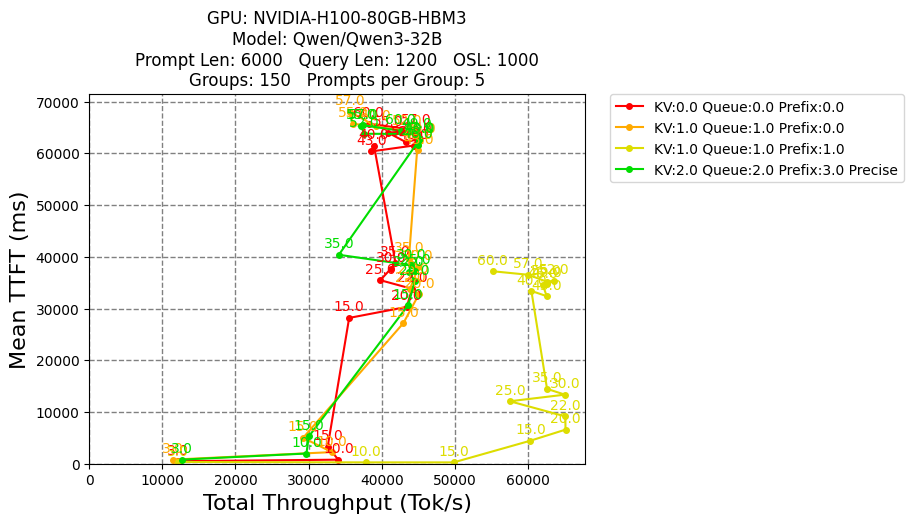

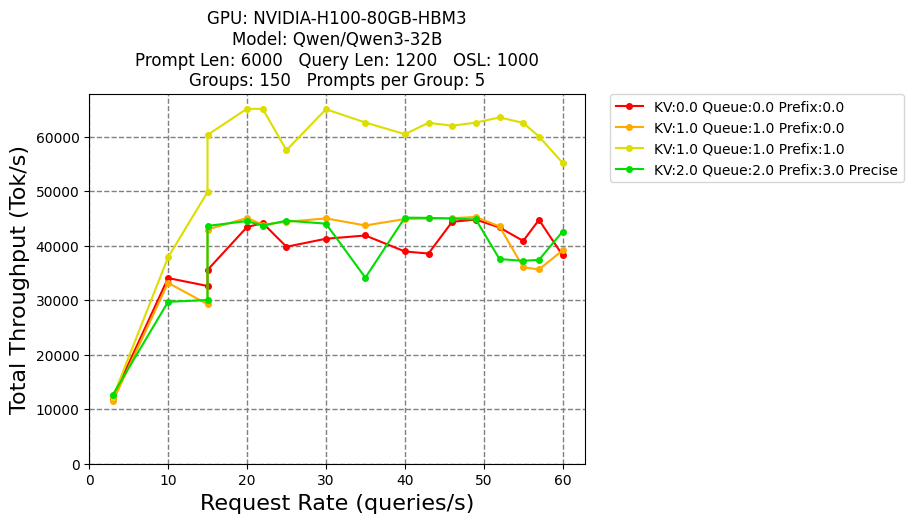

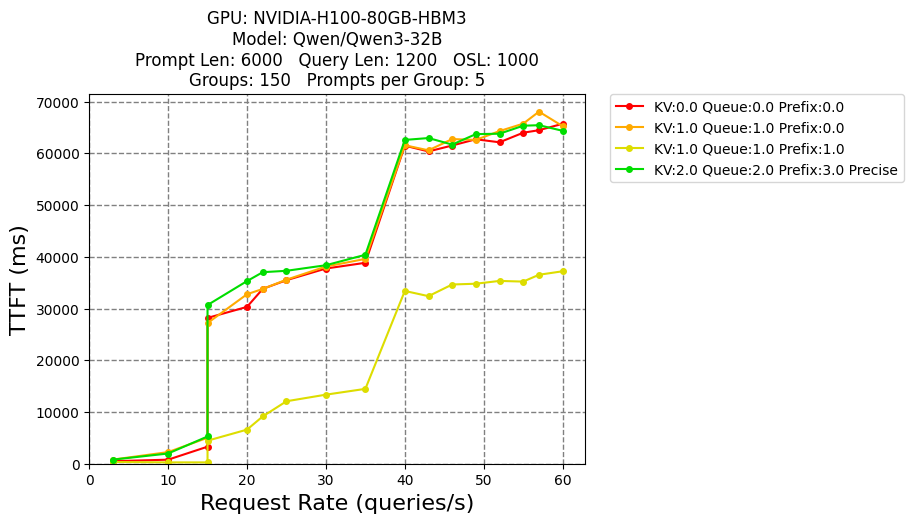

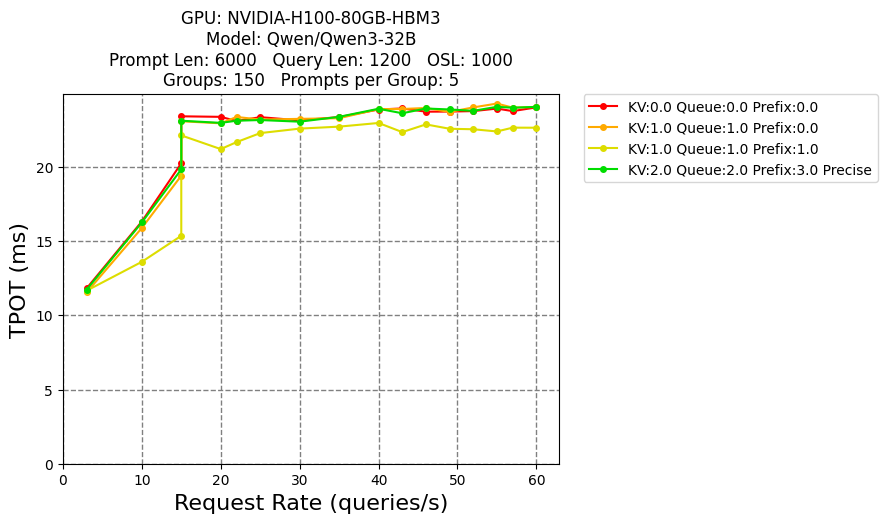

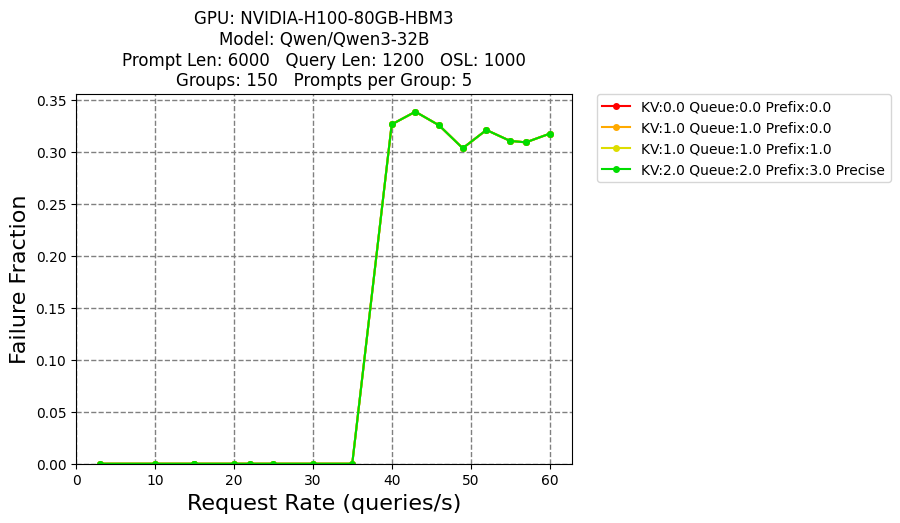

In [16]:
################################################################################
# User inputs
################################################################################

# Select scenario
idx = 0

# Print tables
print_tables = False

# Segregate traces by directory (data with matching scorer weights will only
# be joined if they originate from benchmark reports in the same directory).
# This is helpful if repeated runs are performed. If an experimental run is
# extended through a follow-on run, setting this to "False" will allow the
# data in the plot to be joined.
seg_by_dir = True

################################################################################
# Standard code
################################################################################

plot_scenario(runs, scenarios, idx, print_tables, seg_by_dir)

### Plot all scenarios

In [ ]:
################################################################################
# User inputs
################################################################################

# Print tables
print_tables = False

# Segregate traces by directory (data with matching scorer weights will only
# be joined if they originate from benchmark reports in the same directory).
# This is helpful if repeated runs are performed. If an experimental run is
# extended through a follow-on run, setting this to "False" will allow the
# data in the plot to be joined.
seg_by_dir = True

################################################################################
# Standard code
################################################################################

for idx in range(len(scenarios)):
    plot_scenario(runs, scenarios, idx, print_tables, seg_by_dir)